# Segmenting and Clustering Neighborhoods in Toronto
Alejandro Rojas

Coursera Capstone Project

In [1]:
# with the help of this tutorial to read the information https://towardsdatascience.com/step-by-step-tutorial-web-scraping-wikipedia-with-beautifulsoup-48d7f2dfa52d
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen

## First Step: Creating the initial data frame
We add the URL to procced with our Web Scapping

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')

We find the table and iterate taking into account the rules:
- Cells with not assigned borough will be skipped
- If multiple neighborhoods have the same postal code, they will be both added with a comma separating them
- If a cell has borough but not a neighborhood, then neighborhood will be equal to borough

In [3]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [4]:
df[df.PostalCode.isin(['M5G', 'M2H', 'M4B', 'M1J', 'M5A'])]

,PostalCode,Borough,Neighborhood
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
24,M5G,Downtown Toronto,Central Bay Street
27,M2H,North York,Hillcrest Village
32,M1J,Scarborough,Scarborough Village


Now, let's check the size of our dataframe

In [5]:
df.shape

(103, 3)

## Step 2: Adding the coordinates for each row
I was getting a lot of denied requests from geocoder package, so I ended up using the csv file :(

In [6]:
postal_code_coordinates = pd.read_csv('Geospatial_Coordinates.csv')
postal_code_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
new_df = df.set_index('PostalCode').join(postal_code_coordinates.set_index('Postal Code')).reset_index()
new_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


## Step 3: Clustering the Toronto Neighborhoods
We will now proceed to cluster this dataframe we just obtained. We will test both K means and DBScan algorithms and check which one seems to work better

In [8]:
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


Let's create a map of how this neighborhoods look O:

In [9]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [12]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(new_df['Latitude'], new_df['Longitude'], new_df['Borough'], new_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Since we don't want anyone sniffing around our api credentials, we will just save them locally and read them :D

In [13]:
with open('../../api_credentials.json') as json_data:
    api_credentials = json.load(json_data)

In [110]:
CLIENT_ID = api_credentials['CLIENT_ID']
CLIENT_SECRET = api_credentials['CLIENT_SECRET']
#ACCESS_TOKEN = api_credentials['ACCESS_TOKEN']
VERSION = api_credentials['VERSION']
LIMIT = 100

We will now find the top 100 venues around 500m from each of our neighborhood coordinates using the code from one of the workshops

In [111]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [96]:
toronto_venues = getNearbyVenues(names=new_df['Neighborhood'],
                                   latitudes=new_df['Latitude'],
                                   longitudes=new_df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

Oof, that's a lot of neighborhoods!!

Lets find out the size of our new dataframe

In [113]:
print(toronto_venues.shape)
toronto_venues.head()

(2007, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


How many unique categories we have in our newly created dataframe?

In [114]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 259 uniques categories.


Since we have a lot of different categories and both DBScan and Kmeans work a lot better with an actual numeric variable, let's create one hot encoding for all of our variables.

In [115]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
cols = list(toronto_onehot.columns.values)
cols.remove('Neighborhood')
fixed_columns = ['Neighborhood'] + cols
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We should have a data frame with the same 2007 records and a column for each type of venue

In [116]:
toronto_onehot.shape

(2007, 259)

Now we want to group the dataframe for each neighborhood, we will find the mean for each type of venue and find its value

In [117]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
# New Size
toronto_grouped.shape

(100, 259)

Good, we know have a row for each neighborhood and a column for the mean of the frequency for each type of venue on them. Wow... I can see a lot of zeros there, we should trim this to the top 5 venues using the code from the workshop!

All those zeros would make the algorithm to work a lot harder, and could even bring worse results D:.

In [119]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [129]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Clothing Store,Latin American Restaurant,Lounge,Breakfast Spot,Skating Rink,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
1,"Alderwood, Long Branch",Pizza Place,Skating Rink,Coffee Shop,Dance Studio,Pub,Sandwich Place,Playground,Mexican Restaurant,Middle Eastern Restaurant,Metro Station
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pharmacy,Ice Cream Shop,Bridal Shop,Shopping Mall,Sandwich Place,Sushi Restaurant,Frozen Yogurt Shop,Diner
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Accessories Store,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant
4,"Bedford Park, Lawrence Manor East",Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Pharmacy,Ice Cream Shop,Sushi Restaurant,Liquor Store,Café,Thai Restaurant


### Let's start our clustering step!!

Let's find out a good number of clusters using the elbow method!

C:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


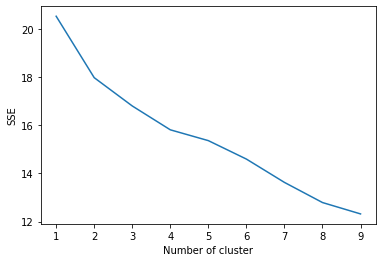

In [121]:
import matplotlib.pyplot as plt
# with the help of https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion#:~:text=The%20idea%20behind%20elbow%20method,for%20each%20value%20of%20k.
sse = {}
sil = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,  random_state = 42).fit(toronto_grouped_clustering)
    label = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

4 clusters looks good, I personally think that more than 8 clusters is really hard for us humans to understand. Overall 5 its harder, so we will stick with 4.

In [122]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0])

It's time to add the cluster number to our dataframe with the top 10 venues, we want to see how similar are our neighborhoods

In [123]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = new_df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Fast Food Restaurant,Park,Food & Drink Shop,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Accessories Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,2.0,Nail Salon,Hockey Arena,Coffee Shop,Grocery Store,Portuguese Restaurant,Metro Station,Men's Store,Mexican Restaurant,Mediterranean Restaurant,Museum
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2.0,Coffee Shop,Bakery,Park,Café,Pub,Restaurant,Sandwich Place,Electronics Store,Event Space,Sushi Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2.0,Clothing Store,Accessories Store,Vietnamese Restaurant,Furniture / Home Store,Coffee Shop,Miscellaneous Shop,Boutique,Middle Eastern Restaurant,Mexican Restaurant,Metro Station
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,2.0,Coffee Shop,Sushi Restaurant,Burrito Place,Yoga Studio,Japanese Restaurant,Burger Joint,Café,Sandwich Place,Salad Place,Music Venue


In [124]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
toronto_merged.dropna(inplace=True)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Lets examine out clusters, maybe we can find something interesting on them!

## Cluster 0

In [125]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,York,0.0,Park,Women's Store,Pool,Accessories Store,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
35,East York/East Toronto,0.0,Park,Convenience Store,Accessories Store,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Mexican Restaurant
52,North York,0.0,Park,Accessories Store,Motel,Martial Arts School,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant
64,York,0.0,Park,Accessories Store,Motel,Martial Arts School,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant
66,North York,0.0,Park,Convenience Store,Accessories Store,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Mexican Restaurant
85,Scarborough,0.0,Intersection,Playground,Park,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Mexican Restaurant
91,Downtown Toronto,0.0,Park,Playground,Trail,Accessories Store,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop


Wow, there is a clear fact here. Park is super common for this neighborhoods. There are another which are pretty common, Accessories Store, Playgrounds, Some restaurants. These ones look pretty cool to live at.

## Cluster 1

In [126]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Etobicoke,1.0,Middle Eastern Restaurant,Accessories Store,Pizza Place,Martial Arts School,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Miscellaneous Shop


This one is unique on its kind. There are no parks here, even though the Accessories Store is pretty close on being the highest.

## Cluster 2

In [127]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,2.0,Fast Food Restaurant,Park,Food & Drink Shop,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Accessories Store
1,North York,2.0,Nail Salon,Hockey Arena,Coffee Shop,Grocery Store,Portuguese Restaurant,Metro Station,Men's Store,Mexican Restaurant,Mediterranean Restaurant,Museum
2,Downtown Toronto,2.0,Coffee Shop,Bakery,Park,Café,Pub,Restaurant,Sandwich Place,Electronics Store,Event Space,Sushi Restaurant
3,North York,2.0,Clothing Store,Accessories Store,Vietnamese Restaurant,Furniture / Home Store,Coffee Shop,Miscellaneous Shop,Boutique,Middle Eastern Restaurant,Mexican Restaurant,Metro Station
4,Queen's Park,2.0,Coffee Shop,Sushi Restaurant,Burrito Place,Yoga Studio,Japanese Restaurant,Burger Joint,Café,Sandwich Place,Salad Place,Music Venue
...,...,...,...,...,...,...,...,...,...,...,...,...
98,Etobicoke,2.0,River,Pool,Accessories Store,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Middle Eastern Restaurant
99,Downtown Toronto,2.0,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Coffee Shop,Mediterranean Restaurant,Indian Restaurant,Burrito Place,Gym,Fast Food Restaurant
100,East Toronto Business,2.0,Yoga Studio,Skate Park,Garden,Light Rail Station,Fast Food Restaurant,Brewery,Smoke Shop,Farmers Market,Burrito Place,Auto Workshop
101,Etobicoke,2.0,Baseball Field,Accessories Store,Movie Theater,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop


Wow, almost the rest of the neighborhoods are here. This is not an amazing result, we can barely learn something here :(

## Cluster 3

In [128]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Scarborough,3.0,Bar,Accessories Store,Movie Theater,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop


Another unique on its kind. Probably due the bar? At least no parks around this one.

#### Some Conclusions
We can try more or differerent clustering algorithms, maybe even try to scale the data because neighborhoods with just an small amount of some venues can generate some imbalanced clusters.

Still, cluster 0 revealed some cool information. If someone lived on one of them, we could for sure suggest them about considering some of those other places to live at =).

That's all for this project, thank you for taking the time of reading this notebook. I wish you the best of luck on the rest of the course!